In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.join('../'))))

In [2]:
import numpy

# train_filtration_diagrams = numpy.load("4__train_filtration_diagrams.npy")
# train_pointcloud_diagrams = numpy.load("4__train_pointcloud_diagrams.npy")

# test_filtration_diagrams = numpy.load("4__test_filtration_diagrams.npy")
# test_pointcloud_diagrams = numpy.load("4__test_pointcloud_diagrams.npy")

In [4]:
import typing

import numpy
import joblib
import gtda.curves
import sklearn.base
import gtda.diagrams
import numpy.ma.core

from cvtda.utils import set_random_seed
from cvtda.logging import DevNullLogger, CLILogger

class FeatureCalculator(sklearn.base.TransformerMixin):
    def __init__(
        self,
        n_jobs: int = -1,
        verbose: bool = True,
        random_state: int = 42,

        n_bins: int = 128,
        batch_size: int = 4096,
        filtering_percentile: int = 10,
        
        persistence_landscape_layers: int = 4,
        silhouette_powers: typing.List[int] = [ 1, 2 ],
        heat_kernel_sigmas: typing.List[float] = [ 0.1, 1.0, numpy.pi ],
        persistence_image_sigmas: typing.List[float] = [ 0.1, 1.0, numpy.pi ]
    ):
        self.fitted_ = False
        self.n_jobs_ = n_jobs
        self.random_state_ = random_state
        set_random_seed(self.random_state_)
        self.logger_ = CLILogger() if verbose else DevNullLogger()

        self.n_bins_ = n_bins
        self.batch_size_ = batch_size
        self.filtering_percentile_ = filtering_percentile
        
        self.betti_curve_ = gtda.diagrams.BettiCurve(n_bins = n_bins, n_jobs = 1)

        self.persistence_landscape_ = gtda.diagrams.PersistenceLandscape(n_layers = persistence_landscape_layers, n_bins = n_bins, n_jobs = 1)

        self.silhouettes_ = [
            gtda.diagrams.Silhouette(power = power, n_bins = n_bins, n_jobs = 1)
            for power in silhouette_powers
        ]
        
        self.persistence_entropy_ = gtda.diagrams.PersistenceEntropy(normalize = True, nan_fill_value = 0, n_jobs = 1)
        
        self.number_of_points_ = gtda.diagrams.NumberOfPoints(n_jobs = 1)
        
        self.heat_kernels_ = [
            gtda.diagrams.HeatKernel(sigma = sigma, n_bins = n_bins, n_jobs = 1)
            for sigma in heat_kernel_sigmas
        ]
        
        self.persistence_images_ = [
            gtda.diagrams.PersistenceImage(sigma = sigma, n_bins = n_bins, n_jobs = 1)
            for sigma in persistence_image_sigmas
        ]

    def fit(self, diagrams: numpy.ndarray):
        set_random_seed(self.random_state_)
        
        self.logger_.print('Fitting the calculator')
        self.homology_dimensions_ = numpy.unique(diagrams[:, :, 2])
        
        self.logger_.print('Fitting the filtering')
        self.filtering_epsilon_ = self.determine_filtering_epsilon_(diagrams)
        self.filtering_ = gtda.diagrams.Filtering(epsilon = self.filtering_epsilon_).fit(diagrams)

        self.logger_.print('Fitting the betti curve')
        self.betti_curve_.fit(diagrams)
        
        self.logger_.print('Fitting the persistence landscape')
        self.persistence_landscape_.fit(diagrams)
        
        for silhouette in self.logger_.loop(self.silhouettes_, desc = 'Fitting the silhouettes'):
            silhouette.fit(diagrams)
        
        self.logger_.print('Fitting the persistence entropy')
        self.persistence_entropy_.fit(diagrams)
        
        self.logger_.print('Fitting the number of points')
        self.number_of_points_.fit(diagrams)

        for heat_kernel in self.logger_.loop(self.heat_kernels_, desc = 'Fitting the heat kernels'):
            heat_kernel.fit(diagrams)
            
        for persistence_image in self.logger_.loop(self.persistence_images_, desc = 'Fitting the persistence images'):
            persistence_image.fit(diagrams)

        self.logger_.print('Fitting complete')
        self.fitted_ = True
        return self
    
    def transform(self, diagrams: numpy.ndarray):
        assert self.fitted_ is True
        set_random_seed(self.random_state_)
        
        def transform_batch(batch: numpy.ndarray) -> numpy.ndarray:
            batch = self.filtering_.transform(batch)
            return numpy.hstack([
                self.calc_betti_features_            (batch),
                self.calc_landscape_features_        (batch),
                self.calc_silhouette_features_       (batch),
                self.calc_entropy_features_          (batch),
                self.calc_number_of_points_features_ (batch),
                self.calc_heat_features_             (batch),
                self.calc_persistence_image_features_(batch),
                self.calc_lifetime_features_         (batch)
            ])

        loop = range(0, len(diagrams), self.batch_size_)
        features = joblib.Parallel(return_as = 'generator', n_jobs = self.n_jobs_)(
            joblib.delayed(transform_batch)(diagrams[batch_start:batch_start + self.batch_size_])
            for batch_start in loop
        )

        collector = self.logger_.loop(features, total = len(loop), desc = 'Batch')
        return numpy.vstack(list(collector))



    def determine_filtering_epsilon_(self, diagrams: numpy.ndarray) -> float:
        life = (diagrams[:, :, 1] - diagrams[:, :, 0]).flatten()
        return numpy.percentile(life[life != 0], self.filtering_percentile_)


    def calc_sequence_stats_(self, data: typing.Union[numpy.ndarray, numpy.ma.core.MaskedArray], axis: int = 1) -> numpy.ndarray:
        # if axis = 1, data should be of shape (n_diagrams, sequence_length)
        if type(data) == numpy.ma.core.MaskedArray:
            return numpy.ma.concatenate([
                numpy.ma.max(data, axis = axis, keepdims = True),
                numpy.ma.sum(data, axis = axis, keepdims = True),
                numpy.ma.mean(data, axis = axis, keepdims = True),
                numpy.ma.std(data, axis = axis, keepdims = True),
                numpy.ma.median(data, axis = axis, keepdims = True),
                numpy.ma.sum(numpy.ma.abs(data), axis = axis, keepdims = True), # manhattan norm
                numpy.ma.sqrt(numpy.ma.sum(data ** 2, axis = axis, keepdims = True)), # euclidean norm
                numpy.ma.max(numpy.ma.abs(data), axis = axis, keepdims = True), # infinity norm
            ], axis = axis).filled(0)
        else:
            return numpy.concatenate([
                numpy.max(data, axis = axis, keepdims = True),
                numpy.sum(data, axis = axis, keepdims = True),
                numpy.mean(data, axis = axis, keepdims = True),
                numpy.std(data, axis = axis, keepdims = True),
                numpy.median(data, axis = axis, keepdims = True),
                numpy.sum(numpy.abs(data), axis = axis, keepdims = True), # manhattan norm
                numpy.sqrt(numpy.sum(data ** 2, axis = axis, keepdims = True)), # euclidean norm
                numpy.max(numpy.abs(data), axis = axis, keepdims = True), # infinity norm
            ], axis = axis)

    def calc_perdim_sequence_stats_(self, data: numpy.ndarray) -> numpy.ndarray:
        # data should be of shape (n_diagrams, n_dimensions, sequence_length)
        
        # (n_dimensions, n_diagrams, n_features)
        per_dim = numpy.array([
            self.calc_sequence_stats_(data[:, dim, :])
            for dim in range(data.shape[1])
        ])
        return numpy.hstack(per_dim)

        # (n_features, n_diagrams, n_features)
        cross_dim = self.calc_sequence_stats_(per_dim, axis = 0)

        return numpy.hstack([ *per_dim, *cross_dim ])
    

    def calc_betti_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        betti_curves = self.betti_curve_.transform(diagrams)
        betti_curve_derivatives = gtda.curves.Derivative().fit_transform(betti_curves)
        return numpy.hstack([
            self.calc_perdim_sequence_stats_(betti_curves),
            self.calc_perdim_sequence_stats_(betti_curve_derivatives)
        ])
        
    def calc_landscape_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        n_layers = self.persistence_landscape_.n_layers
        landscape = self.persistence_landscape_.transform(diagrams)
        return numpy.hstack([
            self.calc_perdim_sequence_stats_(landscape[:, layer::n_layers, :])
            for layer in range(n_layers)
        ])

    def calc_silhouette_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        return numpy.hstack([
            self.calc_perdim_sequence_stats_(silhouette.transform(diagrams))
            for silhouette in self.silhouettes_
        ])

    def calc_entropy_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        return self.persistence_entropy_.transform(diagrams)
    
    def calc_number_of_points_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        return self.number_of_points_.fit_transform(diagrams)
    
    def calc_heat_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        flat_shape = (len(diagrams), len(self.homology_dimensions_), -1)
        return numpy.hstack([
            self.calc_perdim_sequence_stats_(heat_kernel.transform(diagrams).reshape(flat_shape))
            for heat_kernel in self.heat_kernels_
        ])
        
    def calc_persistence_image_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        flat_shape = (len(diagrams), len(self.homology_dimensions_), -1)
        return numpy.hstack([
            self.calc_perdim_sequence_stats_(persistence_image.transform(diagrams).reshape(flat_shape))
            for persistence_image in self.persistence_images_
        ])

    def calc_lifetime_features_(self, diagrams: numpy.ndarray) -> numpy.ndarray:
        birth, death, dim = diagrams[:, :, 0], diagrams[:, :, 1], diagrams[:, :, 2]
        bd2 = (birth + death) / 2.0
        life = death - birth

        bd2_bulk = [ ]
        life_bulk = [ ]
        for d in self.homology_dimensions_:
            mask = (dim != d) | (life < self.filtering_epsilon_)
            bd2_bulk.append(numpy.ma.array(bd2, mask = mask))
            life_bulk.append(numpy.ma.array(life, mask = mask))

        return numpy.hstack([
            self.calc_perdim_sequence_stats_(numpy.ma.stack(bd2_bulk, axis = 1)),
            self.calc_perdim_sequence_stats_(numpy.ma.stack(life_bulk, axis = 1))
        ])


In [4]:
filtraion_fc = FeatureCalculator(n_bins = 64).fit(train_filtration_diagrams)

Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:27<00:00, 13.68s/it]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:47<00:00, 15.92s/it]

Fitting complete


In [5]:
# train_filtration_features = filtraion_fc.transform(train_filtration_diagrams)
# numpy.save("5__train_filtration_features.npy", train_filtration_features)

train_filtration_features = numpy.load("5__train_filtration_features.npy")
train_filtration_features.shape

(2940000, 260)

In [6]:
# test_filtration_features = filtraion_fc.transform(test_filtration_diagrams)
# numpy.save("5__test_filtration_features.npy", test_filtration_features)

test_filtration_features = numpy.load("5__test_filtration_features.npy")
test_filtration_features.shape

(490000, 260)

In [12]:
pointcloud_fc = FeatureCalculator(batch_size = 1024).fit(train_pointcloud_diagrams)

Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:15<00:00,  5.20s/it]

Fitting complete


In [7]:
# train_pointcloud_features = pointcloud_fc.transform(train_pointcloud_diagrams)
# numpy.save("5__train_pointcloud_features.npy", train_pointcloud_features)

train_pointcloud_features = numpy.load("5__train_pointcloud_features.npy")
train_pointcloud_features.shape

(120000, 390)

In [8]:
# test_pointcloud_features = pointcloud_fc.transform(test_pointcloud_diagrams)
# numpy.save("5__test_pointcloud_features.npy", test_pointcloud_features)

test_pointcloud_features = numpy.load("5__test_pointcloud_features.npy")
test_pointcloud_features.shape

(20000, 390)

In [9]:
import torchvision

train = torchvision.datasets.MNIST('mnist', train = True, download = False)
test = torchvision.datasets.MNIST('mnist', train = False, download = False)

train_images = numpy.array([ item[0] for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ item[0] for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

In [10]:
import tqdm

def make_features(images: numpy.ndarray, filtration_features: numpy.ndarray, pointcloud_features: numpy.ndarray):
    filtrations_per_image = len(filtration_features) // len(images)
    point_clouds_per_image = len(pointcloud_features) // len(images)
    
    features = [ ]
    for img_idx in tqdm.trange(len(images), desc = 'combine features'):
        idx1 = filtrations_per_image * img_idx
        idx2 = filtrations_per_image * (img_idx + 1)
        filtration_features_flat = filtration_features[idx1:idx2].flatten()
        
        idx1 = point_clouds_per_image * img_idx
        idx2 = point_clouds_per_image * (img_idx + 1)
        pointcloud_features_flat = pointcloud_features[idx1:idx2].flatten()
        
        features_flat = numpy.concatenate((filtration_features_flat, pointcloud_features_flat), axis = 0)
        features.append(features_flat)

    return numpy.array(features)

train_features = make_features(train_images, train_filtration_features, train_pointcloud_features)
test_features = make_features(test_images, test_filtration_features, test_pointcloud_features)

combine features: 100%|██████████| 10000/10000 [00:00<00:00, 16339.83it/s]


In [11]:
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

In [20]:
import sklearn.ensemble
import torch

In [21]:
rf = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 100)
rf.fit(train_features, train_labels)
print(rf.score(test_features, test_labels))

0.973


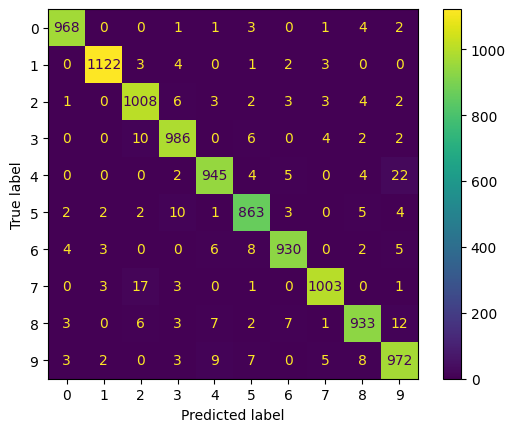

In [22]:
predictions = rf.predict(test_features)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions)

In [11]:
import sklearn.preprocessing

sc = sklearn.preprocessing.StandardScaler()
train_features_scaled = sc.fit_transform(train_features)
test_features_scaled = sc.fit_transform(test_features)

In [24]:
rf = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 100)
rf.fit(train_features_scaled, train_labels)
print(rf.score(test_features_scaled, test_labels))

0.9733


In [25]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 10)
rf.fit(train_features_scaled, train_labels)
print(rf.score(test_features_scaled, test_labels))

0.9431


In [26]:
pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)
train_features_reduced = pca.fit_transform(train_features_scaled)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
test_features_reduced = pca.transform(test_features_scaled)

Explained variance 0.9
[0.291, 0.11, 0.049, 0.038, 0.034, 0.027, 0.026, 0.023, 0.018, 0.013, 0.012, 0.011, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


In [27]:
rf_reduced = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
rf_reduced.fit(train_features_reduced, train_labels)
print(rf_reduced.score(test_features_reduced, test_labels))

0.9463


In [28]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 10)
rf.fit(train_features_reduced, train_labels)
print(rf.score(test_features_reduced, test_labels))

0.9436


In [13]:
import torch
import random
import sklearn.metrics

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

device = torch.device("cuda")


train_ds = torch.utils.data.TensorDataset(
    torch.tensor(train_features_scaled, dtype = torch.float),
    torch.tensor(train_labels, dtype = torch.long)
)

test_ds = torch.utils.data.TensorDataset(
    torch.tensor(test_features_scaled, dtype = torch.float),
    torch.tensor(test_labels, dtype = torch.long)
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 1024, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 1024, shuffle = False)

model = torch.nn.Sequential(
    torch.nn.Linear(train_features_scaled.shape[1], 256), torch.nn.BatchNorm1d(256), torch.nn.GELU(),
    torch.nn.Linear(256, 128), torch.nn.BatchNorm1d(128), torch.nn.GELU(),
    torch.nn.Linear(128, 64), torch.nn.BatchNorm1d(64), torch.nn.GELU(),
    torch.nn.Linear(64, 32), torch.nn.BatchNorm1d(32), torch.nn.GELU(),
    torch.nn.Linear(32, 10)
).to(device)

optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = 3e-4
)

for epoch in range(50):
    model.train()
    for (X, y) in train_dl:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = torch.nn.functional.cross_entropy(pred, y.to(device), reduction = 'sum')
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        preds = [ ]
        Y = [ ]
        for batch_x, batch_y in test_dl:
            preds.extend(torch.argmax(model(batch_x.to(device)), axis = 1).cpu())
            Y.extend(batch_y)
        accuracy = sklearn.metrics.accuracy_score(Y, preds)

    print(f"epoch {epoch}: loss = {loss.item()}, acc = {accuracy}")

epoch 0: loss = 525.3291015625, acc = 0.9441
epoch 1: loss = 370.4239501953125, acc = 0.9645
epoch 2: loss = 250.3341827392578, acc = 0.9719
epoch 3: loss = 199.0609130859375, acc = 0.9768
epoch 4: loss = 154.646484375, acc = 0.9755
epoch 5: loss = 135.6269073486328, acc = 0.9779
epoch 6: loss = 100.31880187988281, acc = 0.9801
epoch 7: loss = 87.72145080566406, acc = 0.9807
epoch 8: loss = 70.30985260009766, acc = 0.9814
epoch 9: loss = 60.046058654785156, acc = 0.9808
epoch 10: loss = 48.65582275390625, acc = 0.9762
epoch 11: loss = 40.32211685180664, acc = 0.9801
epoch 12: loss = 35.00477600097656, acc = 0.9828
epoch 13: loss = 29.42571449279785, acc = 0.9815
epoch 14: loss = 26.892322540283203, acc = 0.9787
epoch 15: loss = 28.21523666381836, acc = 0.9817
epoch 16: loss = 20.82664680480957, acc = 0.9815
epoch 17: loss = 21.68097686767578, acc = 0.9811
epoch 18: loss = 19.88215446472168, acc = 0.9793
epoch 19: loss = 18.8137149810791, acc = 0.9779
epoch 20: loss = 19.069021224975586

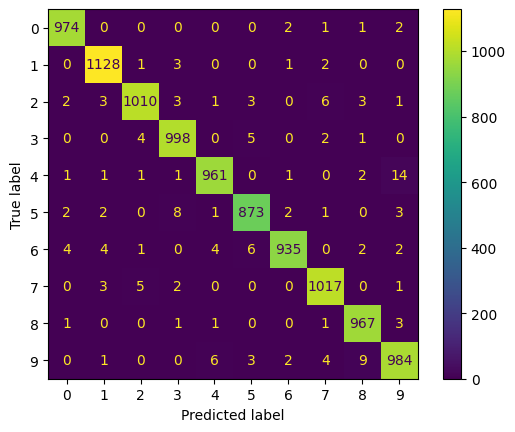

In [14]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, numpy.array(preds))

In [21]:
a = numpy.where(test_labels != numpy.array(preds))[0]
print(a)
print(test_labels[a])
print(numpy.array(preds)[a])
print(len(a))

[ 324  340  445  447  449  625  689  883  938  947  956 1014 1021 1178
 1226 1232 1242 1247 1260 1393 1500 1597 1611 1654 1676 1678 1772 1901
 1982 2018 2035 2053 2098 2125 2129 2130 2135 2182 2215 2225 2266 2293
 2326 2369 2406 2414 2433 2447 2454 2462 2488 2496 2582 2597 2643 2654
 2735 2771 2929 2939 2944 3005 3060 3073 3172 3365 3369 3422 3520 3524
 3558 3702 3726 3762 3767 3811 3853 4017 4065 4078 4201 4205 4289 4360
 4382 4425 4438 4497 4571 4619 4731 4738 4740 4761 4783 4808 4823 4878
 5140 5159 5449 5734 5735 5757 5833 5835 5877 5937 5955 5997 6042 6139
 6173 6544 6554 6558 6560 6562 6576 6592 6597 6598 6607 6625 6632 6700
 6783 7400 7483 7603 7613 8059 8092 8094 8112 8287 8290 8316 8527 8532
 8759 9009 9530 9669 9672 9698 9703 9729 9749 9770 9792 9850 9905]
[0 5 6 4 3 6 7 3 3 8 1 6 7 4 7 9 4 9 7 5 7 9 3 2 6 2 7 9 6 1 5 4 2 5 9 4 6
 1 6 8 1 9 0 5 9 9 2 4 6 2 2 2 9 5 6 6 9 4 9 9 0 9 9 1 4 6 9 6 6 6 5 5 4 6
 7 2 6 4 0 9 1 2 2 5 4 9 4 8 6 6 8 4 3 9 4 3 9 2 3 4 2 3 5 9 5 7 6 5 3 5 

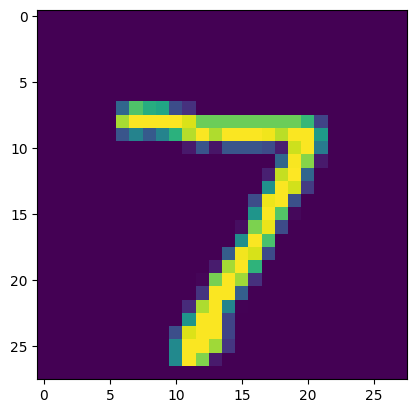

In [49]:
import matplotlib.pyplot as plt

plt.imshow(test_images[0])

In [72]:
import scipy.spatial.distance

scipy.spatial.distance.pdist

<function scipy.spatial.distance.pdist(X, metric='euclidean', *, out=None, **kwargs)>

In [ ]:
['', '', '', '', '', '', '', '', '', '', '', 'nan_euclidean', '']

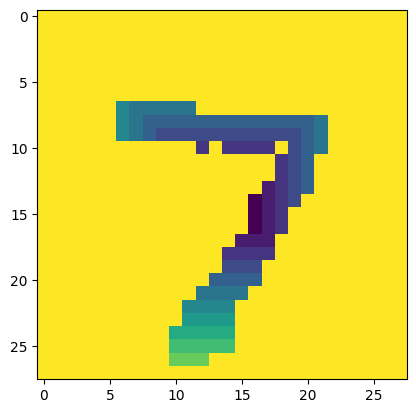

In [120]:
import gtda.images

# chebyshev, euclidean, manhattan

b = gtda.images.Binarizer(threshold = 0.1)
df = gtda.images.RadialFiltration(center = numpy.array([ 14, 14 ]), metric = 'chebyshev')


plt.imshow(df.fit_transform(b.fit_transform(test_images[:10]))[0])

In [123]:
import gtda.homology

b = gtda.images.Binarizer(threshold = 0.1)
df = gtda.images.RadialFiltration(center = numpy.array([ 14, 14 ]), metric = 'chebyshev')

imgs = df.fit_transform(b.fit_transform(test_images[:10]))

cf = gtda.homology.CubicalPersistence()
cf.fit_transform_plot(imgs)

array([[[ 4.,  5.,  0.],
        [ 5., 15.,  1.]]])

In [128]:
import gtda.homology

b = gtda.images.Binarizer(threshold = 0.1)
df = gtda.images.RadialFiltration(center = numpy.array([ 14, 14 ]), metric = 'manhattan')

imgs = df.fit_transform(b.fit_transform(test_images[:10]))

cf = gtda.homology.CubicalPersistence()
cf.fit_transform_plot(imgs)

array([[[ 4.,  7.,  0.],
        [ 9., 29.,  1.]]])

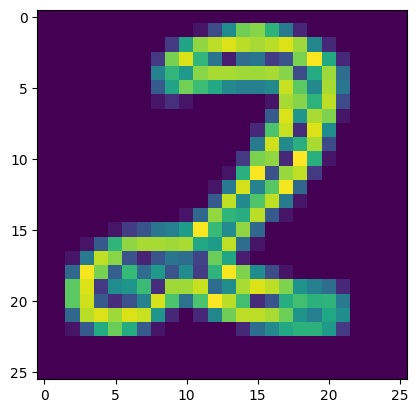

In [45]:
import torch

sobel_hor = [
    [-3., -10, -3], 
    [0, 0, 0], 
    [3, 10, 3]
]

sobel_ver = [
    [-3, 0, 3], 
    [-10, 0, 10], 
    [-3, 0, 3]
]

t = torch.tensor(test_images[477], dtype = torch.float32).unsqueeze(dim = 0).unsqueeze(dim = 0)
k = torch.tensor([[sobel_hor]], dtype = torch.float32)
k2 = torch.tensor([[sobel_ver]], dtype = torch.float32)

img_conv_hor = torch.nn.functional.conv2d(t, k)
img_conv_vet = torch.nn.functional.conv2d(t, k2)

plt.imshow(torch.sqrt(img_conv_hor[0][0] ** 2 + img_conv_vet[0][0] ** 2))

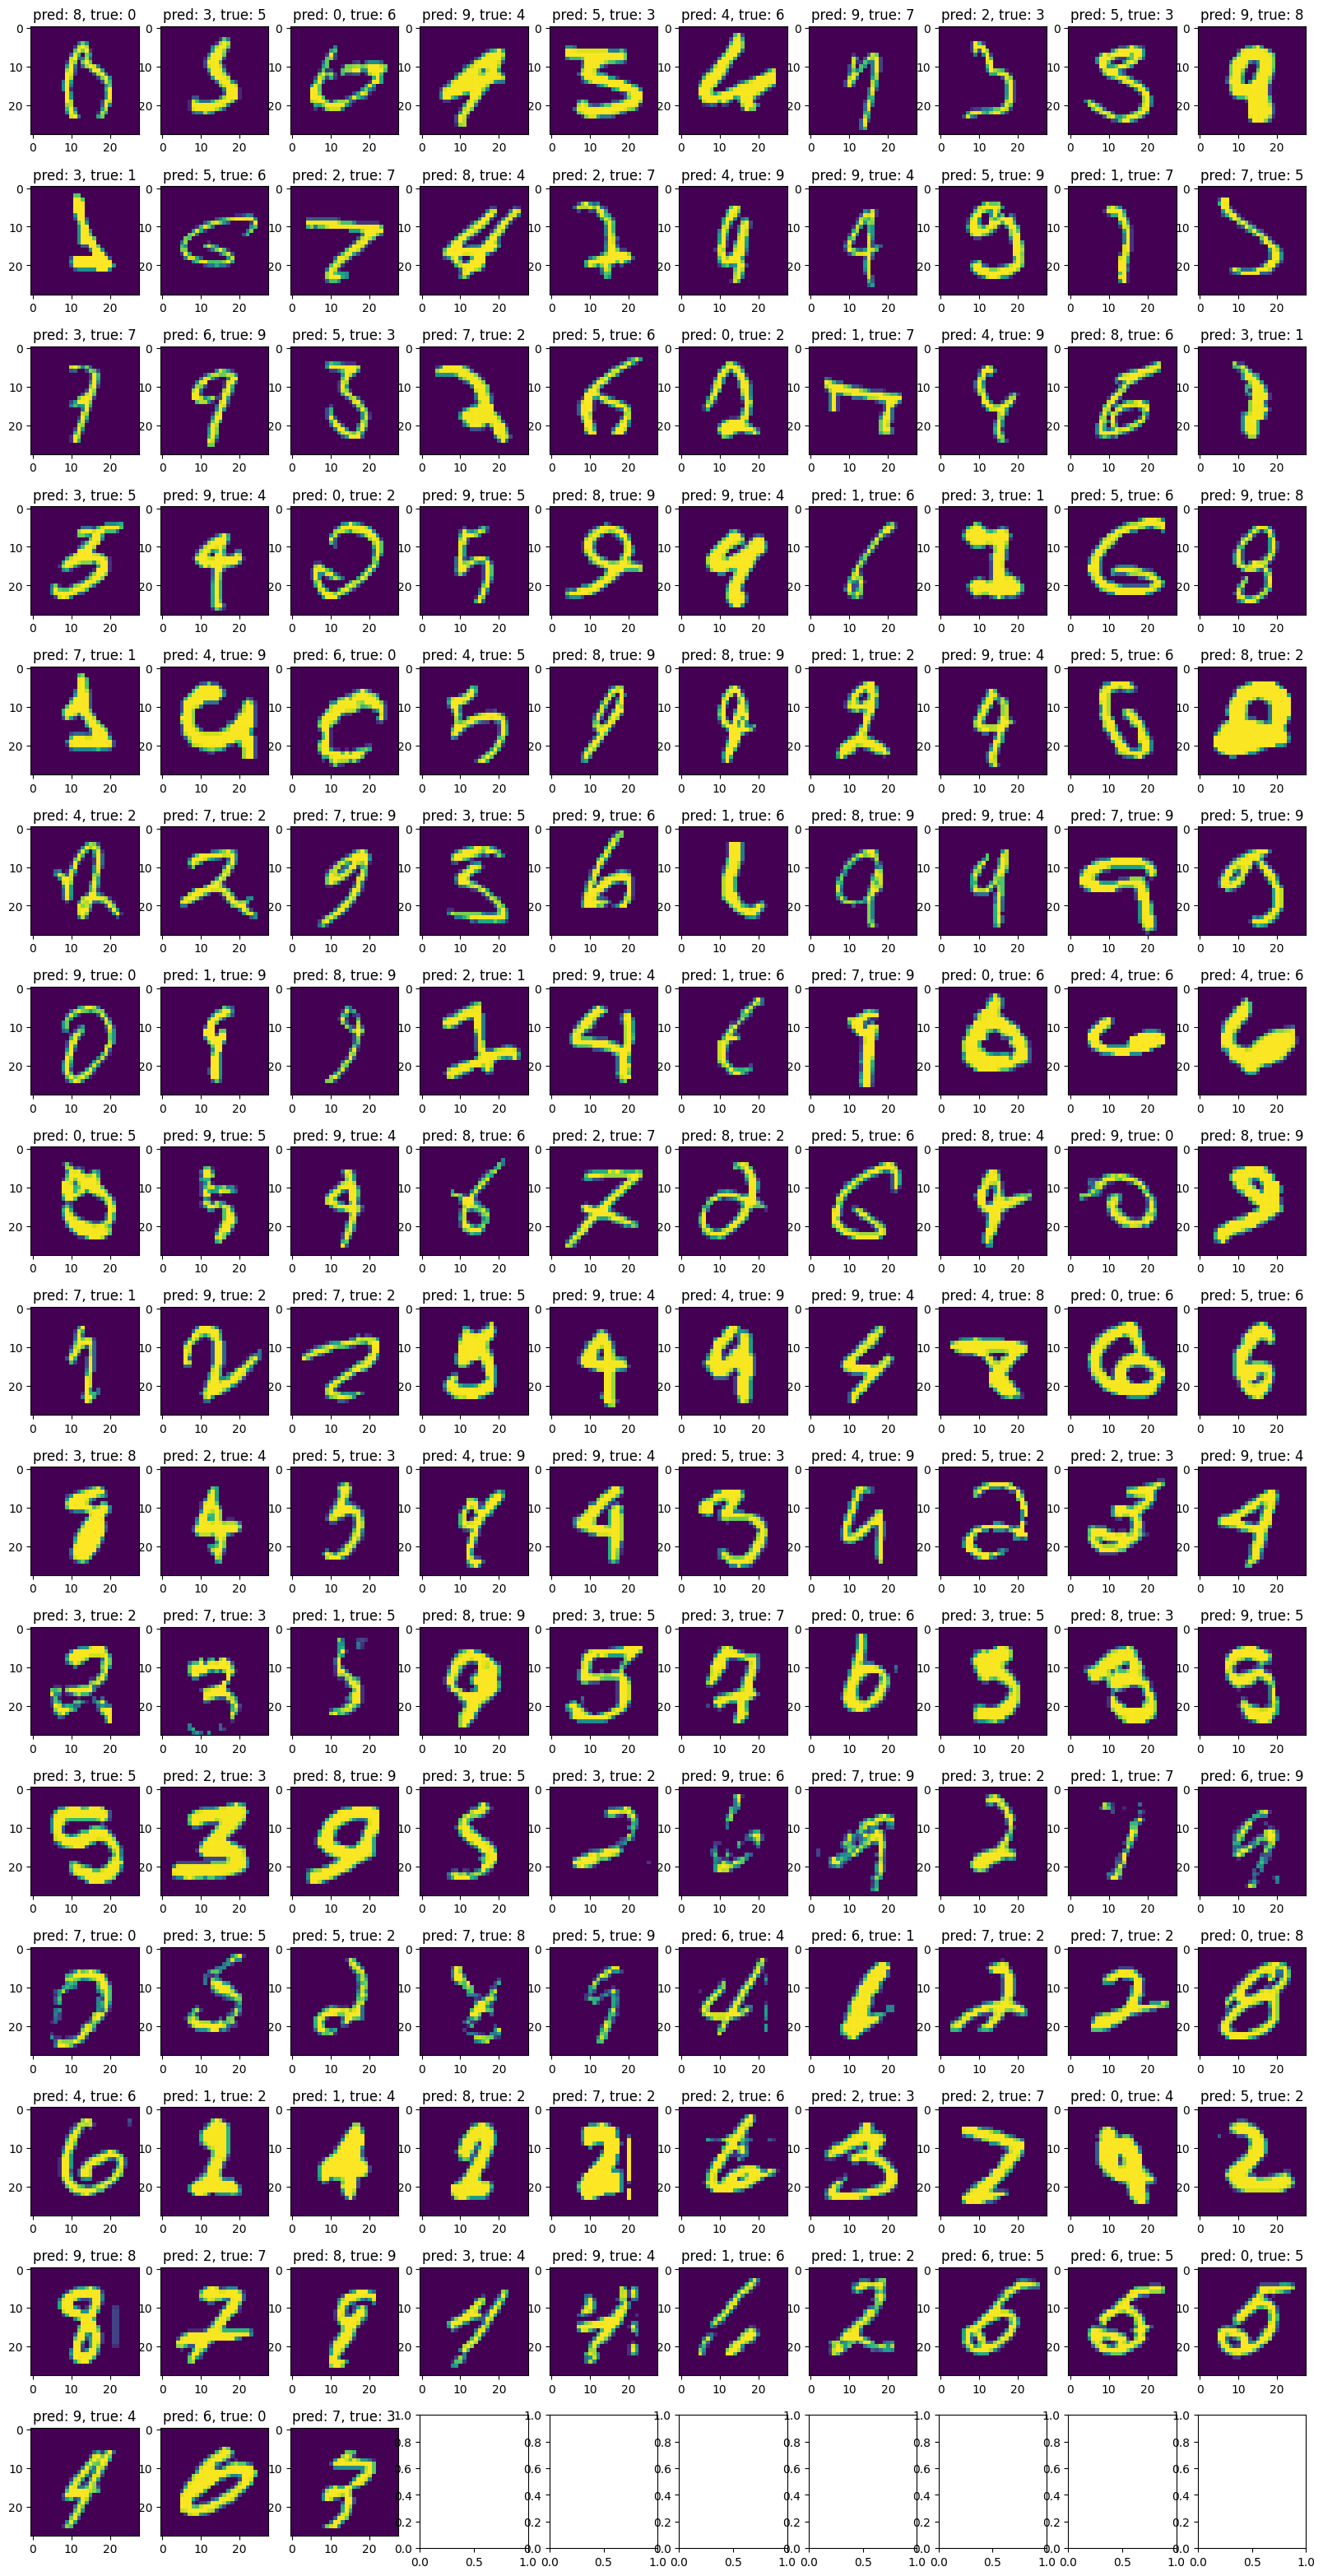

In [40]:

import gtda.images

fig, axes = plt.subplots(16, 10, figsize = (20, 40))
for i, ax in zip(numpy.where(test_labels != numpy.array(preds))[0], axes.flat):
    bin = gtda.images.Binarizer(threshold = 0.1).fit_transform(numpy.array([ test_images[i] ]))[0]
    ax.imshow(bin * test_images[i])
    ax.set_title(f"pred: {preds[i]}, true: {test_labels[i]}")